In [1]:
import json
import sys
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display

project_root = Path.cwd()
if not (project_root / "src" / "dijon").exists():
    project_root = project_root.parent
sys.path.insert(0, str(project_root))

from dijon.global_config import AUDIO_MARKERS_DIR, RAW_AUDIO_DIR
from dijon.chromagram import compute_chromagram
from dijon.notebook_ui import display_audio_with_cursor

%matplotlib inline

In [2]:
def load_section(track: str, section: str, frac=None):
    """Load a section of a track. Returns (x, sr).

    If section is "", load the whole track. Otherwise use {section}_START and
    {section}_END markers (e.g. LICK01, HEAD_IN).
    If frac is set (e.g. 0.25), return only the first frac of the segment.
    """
    audio_path = RAW_AUDIO_DIR / f"{track}.wav"
    x_full, sr = librosa.load(audio_path, sr=None, mono=True)
    if not section:
        x = x_full
    else:
        markers_path = AUDIO_MARKERS_DIR / f"{track}_markers.json"
        with open(markers_path) as f:
            markers_data = json.load(f)
        markers = markers_data["entries"][0]["markers"]
        seg_start = next(m["position"] for m in markers if m["name"] == f"{section}_START")
        seg_end = next(m["position"] for m in markers if m["name"] == f"{section}_END")
        start_sample = int(seg_start * sr)
        end_sample = int(seg_end * sr)
        x = x_full[start_sample:end_sample]
    if frac is not None:
        n = int(len(x) * frac)
        x = x[:n]
    return x, sr

track01, track01_section = "YTB-002", "LICK01"
track02, track02_section = "YTB-005", "LICK01"
track03, track03_section = "YTB-013", "HEAD_IN"
track03_frac = 0.25  # first 25% only

items = [
    ("track01", track01, track01_section, None),
    ("track02", track02, track02_section, None),
    ("track03", track03, track03_section, track03_frac),
]
data = {label: load_section(track, section, frac) for label, track, section, frac in items}
for label, track, section, frac in items:
    x, sr = data[label]
    seg = f" {section}" if section else " (full)"
    if frac is not None:
        seg = f"{seg} (first {frac*100:.0f}%)"
    print(f"{label} {track}{seg}: {len(x)/sr:.2f}s @ {sr} Hz")

track01 YTB-002 LICK01: 13.75s @ 22050 Hz
track02 YTB-005 LICK01: 2.59s @ 22050 Hz
track03 YTB-013 HEAD_IN (first 25%): 7.77s @ 22050 Hz


In [ ]:
N_fft = 2048
H = 512
f_min, f_max = 40, 4000  # typical piano range

chromagrams = {}
for label, track, section, frac in items:
    x, sr = data[label]
    C, times = compute_chromagram(x, sr, N_fft=N_fft, H=H, f_min=f_min, f_max=f_max)
    chromagrams[label] = (C, times)

**track01 YTB-002 LICK01**



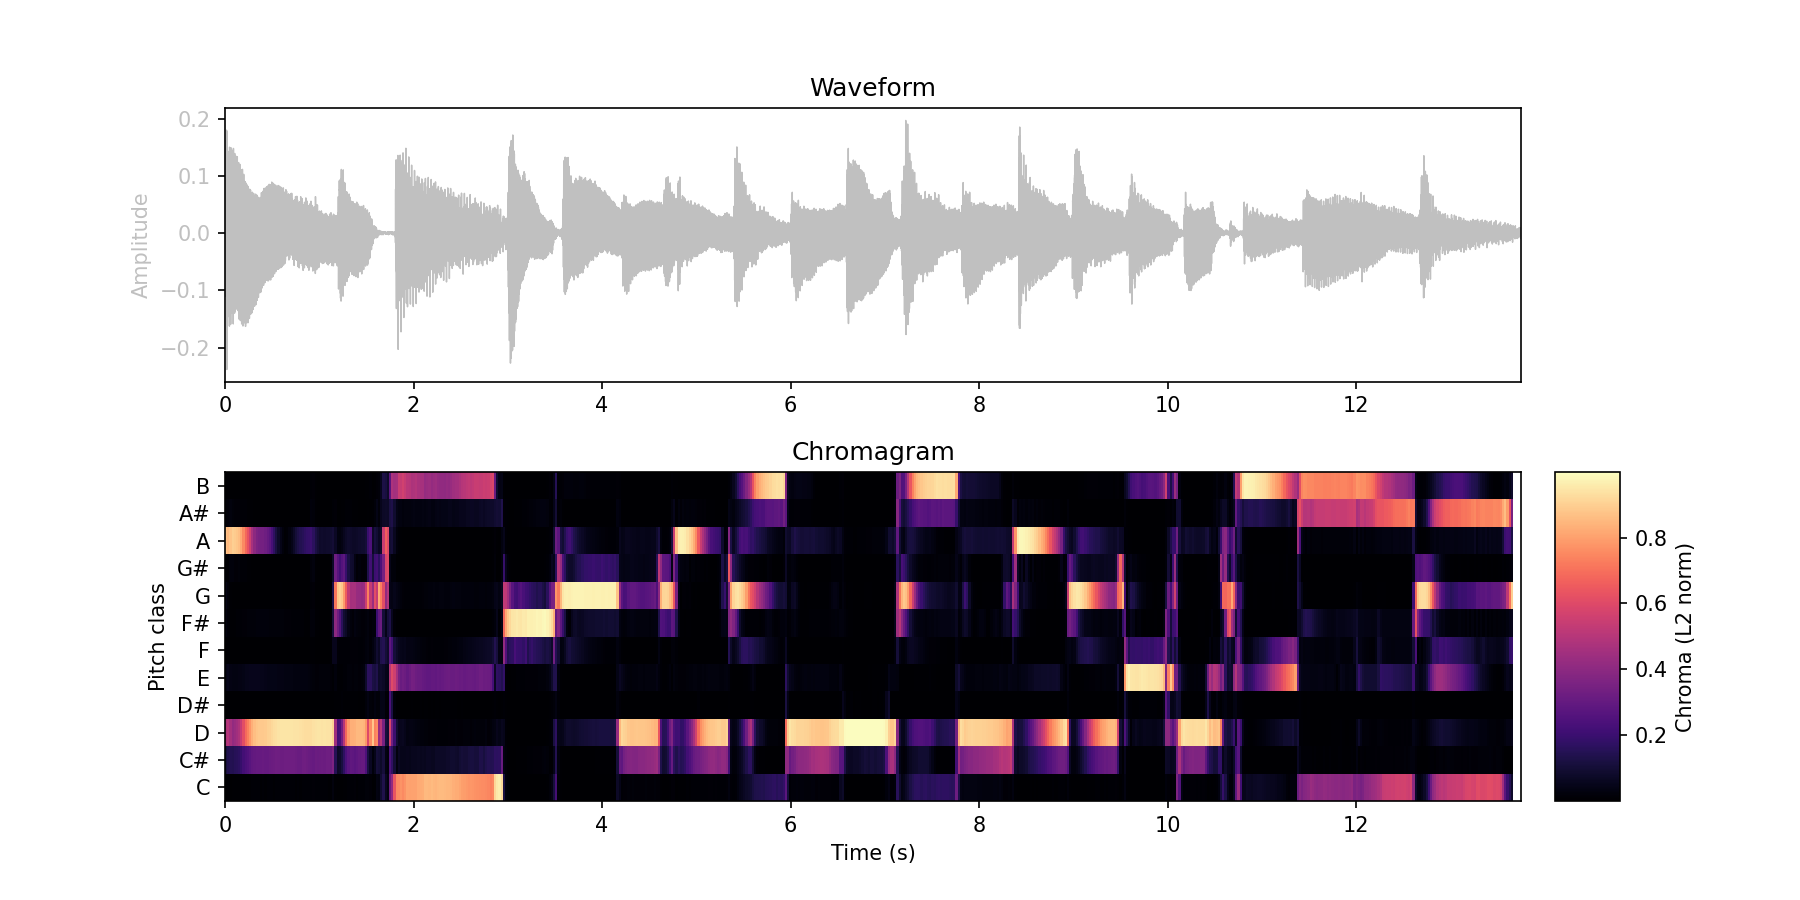

**track02 YTB-005 LICK01**



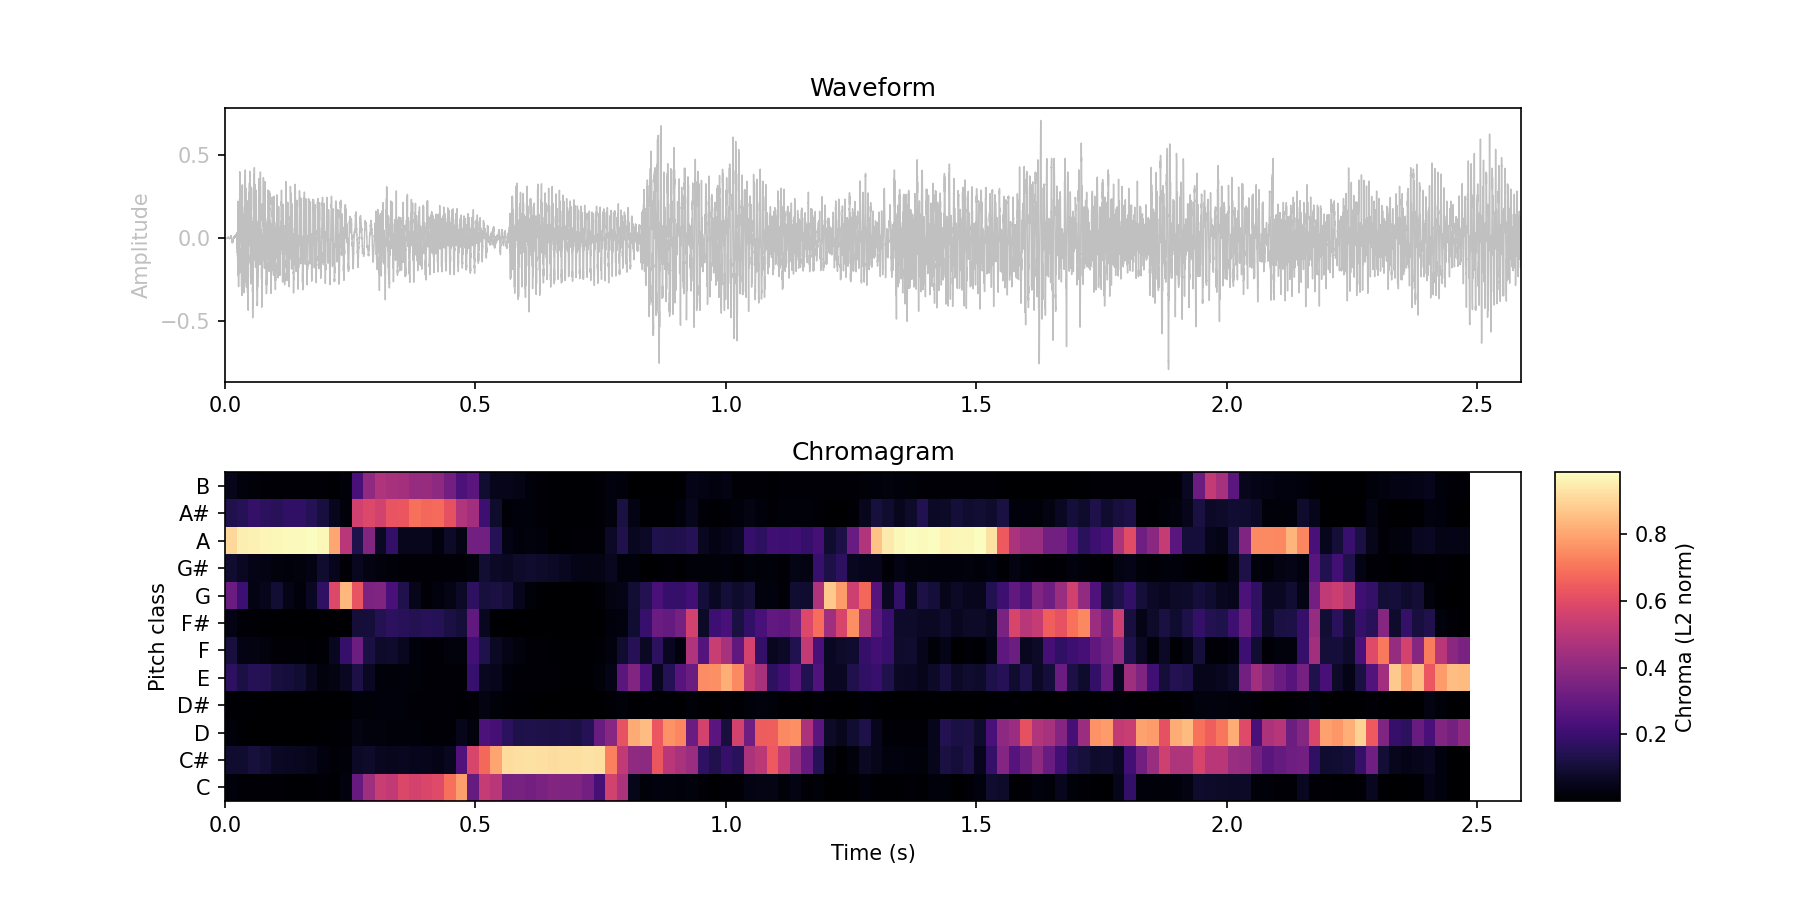

**track03 YTB-013 HEAD_IN (first 25%)**



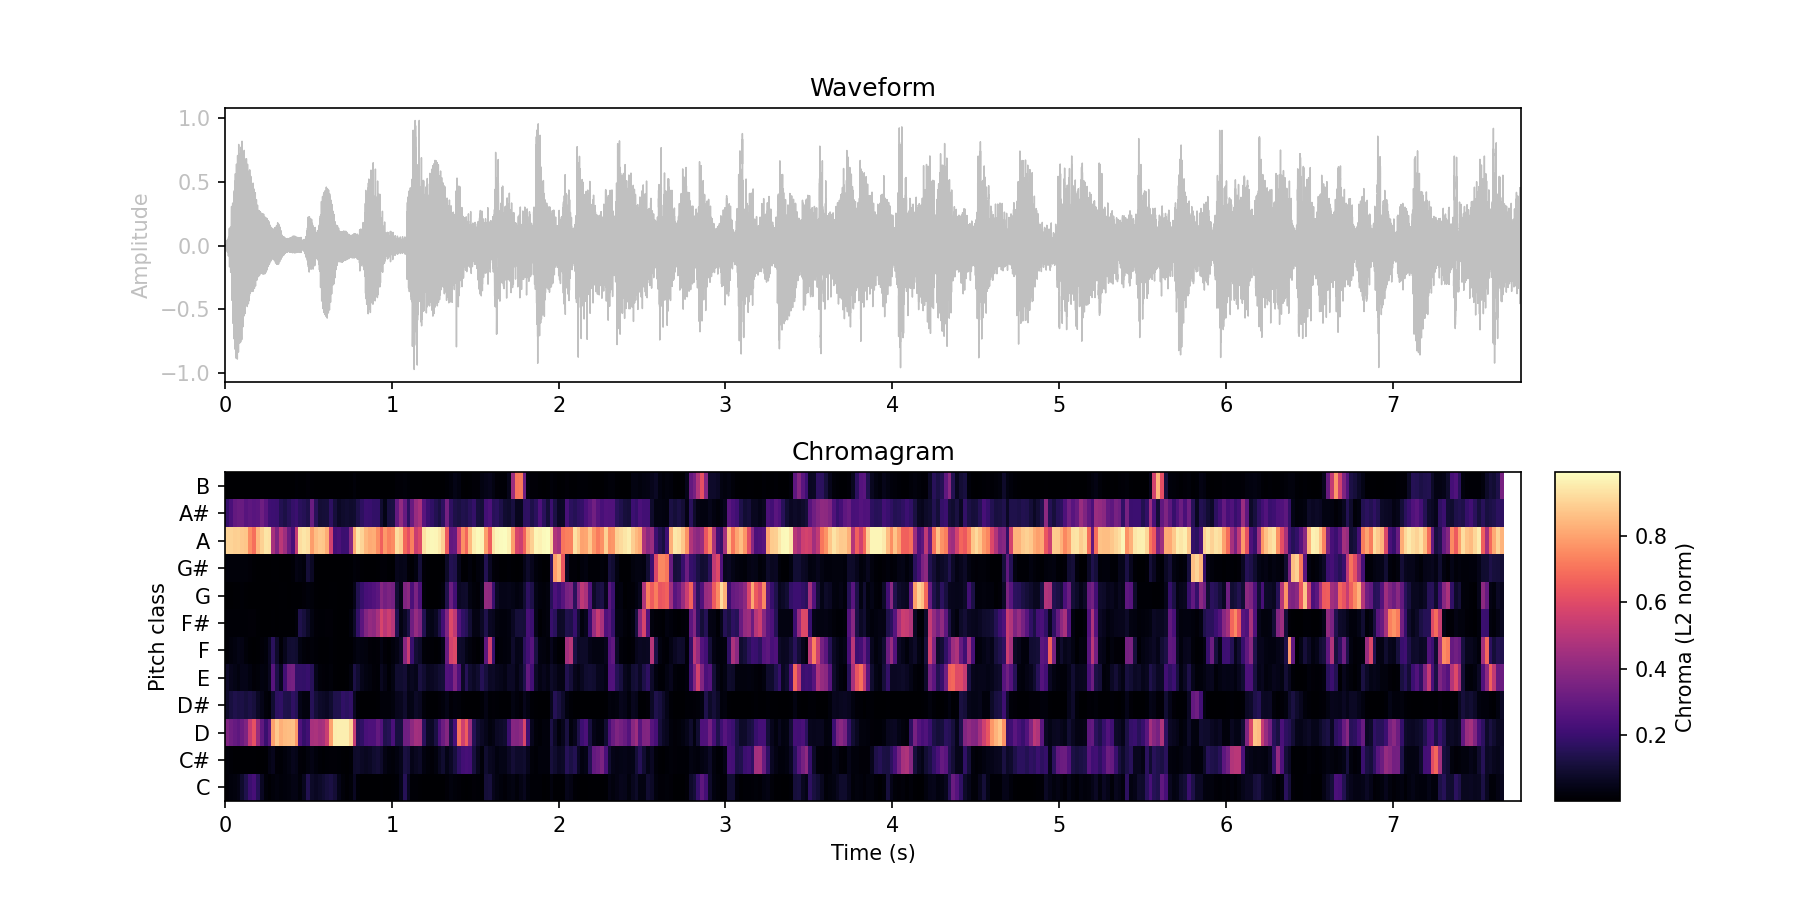

In [4]:
PITCH_CLASS_NAMES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

FIG_WIDTH = 12  # inches, shared by player and chromagram

for label, track, section, frac in items:
    x, sr = data[label]
    C, times = chromagrams[label]
    seg = f" {section}" if section else " (full)"
    if frac is not None:
        seg = f"{seg} (first {frac*100:.0f}%)"
    print(f"**{label} {track}{seg}**")
    duration_s = len(x) / sr
    fig = plt.figure(figsize=(FIG_WIDTH, 6))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2], width_ratios=[20, 1], hspace=0.3, wspace=0.05)
    ax_wave = fig.add_subplot(gs[0, 0])
    ax_chroma = fig.add_subplot(gs[1, 0], sharex=ax_wave)
    ax_cbar = fig.add_subplot(gs[1, 1])
    t = np.arange(len(x)) / sr
    ax_wave.plot(t, x, color="#c0c0c0", linewidth=0.7)
    ax_wave.set_ylabel("Amplitude", color="#c0c0c0")
    ax_wave.set_xlim(0, duration_s)
    ax_wave.tick_params(axis="y", labelcolor="#c0c0c0")
    ax_wave.set_title("Waveform")
    im = ax_chroma.imshow(C, aspect="auto", origin="lower", cmap="magma", interpolation="nearest",
                          extent=[times[0], times[-1], -0.5, 11.5])
    ax_chroma.set_xlim(0, duration_s)
    ax_chroma.set_ylabel("Pitch class")
    ax_chroma.set_yticks(np.arange(12))
    ax_chroma.set_yticklabels(PITCH_CLASS_NAMES)
    ax_chroma.set_xlabel("Time (s)")
    ax_chroma.set_title("Chromagram")
    fig.colorbar(im, cax=ax_cbar, label="Chroma (L2 norm)")
    display_audio_with_cursor(x, sr, fig=fig, ax=ax_wave, close_fig=True)